In [3]:
import requests
import pandas as pd
from google.colab import userdata

In [ ]:
api_token=''

In [5]:
base_url = 'https://api.github.com'
headers = {'Authorization': f'token {api_token}'}

In [6]:
users_data=[]
page = 1
while True:
    users_url = f"{base_url}/search/users?q=location:Toronto+followers:>=100&page={page}&per_page=100"
    response = requests.get(users_url, headers=headers)
    data = response.json()
    if 'items' not in data or not data['items']:
        break
    users_data.extend(data['items'])
    page += 1

In [7]:
# Extracting user info
users = []
for user in users_data:
    user_detail_url = user['url']
    user_response = requests.get(user_detail_url, headers=headers)
    user_info = user_response.json()

    # Cleaning up company name
    company = user_info.get('company', '')
    if company:
        company = company.strip().lstrip('@').upper()

    users.append({
        'login': user_info['login'],
        'name': user_info['name'],
        'company': company,
        'location': user_info['location'],
        'email': user_info['email'],
        'hireable': 'true' if user_info['hireable'] else 'false',
        'bio': user_info['bio'],
        'public_repos': user_info['public_repos'],
        'followers': user_info['followers'],
        'following': user_info['following'],
        'created_at': user_info['created_at']
        })

In [8]:
# Converting to DataFrame and saving it as CSV
users_df = pd.DataFrame(users)
users_df.to_csv('users.csv', index=False)

In [9]:
# Fetching repositories for each user
repos = []
for user in users:
    page = 1
    user_repos=[]
    while True:
        repos_url = f"{base_url}/users/{user['login']}/repos?sort=pushed&direction=desc&page={page}&per_page=100"
        repos_response = requests.get(repos_url, headers=headers)
        repos_data = repos_response.json()
        if not repos_data or len(user_repos) >= 500:
            break
        for repo in repos_data:
            if len(user_repos) >= 500:
                break
        # for repo in repos_data:
            user_repos.append({
                'login': user['login'],
                'full_name': repo['full_name'],
                'created_at': repo['created_at'],
                'stargazers_count': repo['stargazers_count'],
                'watchers_count': repo['watchers_count'],
                'language': repo['language'],
                'has_projects': 'true' if repo['has_projects'] else 'false',
                'has_wiki': 'true' if repo['has_wiki'] else 'false',
                'license_name': repo['license']['name'] if repo['license'] else None
            })
        page+=1
    repos.extend(user_repos)

In [10]:
# Converting to DataFrame and saving it as CSV
repos_df = pd.DataFrame(repos)
repos_df.to_csv('repositories.csv', index=False)



---



In [11]:
users_data = pd.read_csv('users.csv')
repo_data = pd.read_csv('repositories.csv')

1. Who are the top 5 users in Toronto with the highest number of followers? List their login in order, comma-separated.

In [12]:

top_users = users_data.sort_values(by='followers', ascending=False).head(5)
top_usernames = top_users['login'].tolist()
print(','.join(top_usernames))


aneagoie,ZhangMYihua,susanli2016,thedaviddias,ange-yaghi


2. Who are the 5 earliest registered GitHub users in Toronto? List their login in ascending order of created_at, comma-separated.

In [13]:

earliest_toronto_users = users_data.sort_values(by='created_at', ascending=True).head(5)
top_five=earliest_toronto_users['login'].tolist()
print(','.join(top_five))

jamesmacaulay,michaelklishin,myles,nwjsmith,cablehead


3. What are the 3 most popular license among these users? Ignore missing licenses. List the license_name in order, comma-separated.

In [14]:
users_with_license=repo_data.dropna(subset=['license_name'])
top_licenses=users_with_license['license_name'].value_counts().head(3).index.tolist()
print(','.join(top_licenses))


MIT License,Other,Apache License 2.0


4. Which company do the majority of these developers work at?

In [15]:
most_common_company = users_data['company'].dropna().value_counts().idxmax()
print(most_common_company)

UNIVERSITY OF TORONTO


5. Which programming language is most popular among these users?

In [16]:
most_popular_language = repo_data['language'].dropna().value_counts().idxmax()

print(most_popular_language)

JavaScript


6. Which programming language is the second most popular among users who joined after 2020?

In [17]:
filtered_users = users_data[pd.to_datetime(users_data['created_at']).dt.year > 2020]
filtered_repos = repo_data[repo_data['login'].isin(filtered_users['login'])]
language_counts = filtered_repos['language'].dropna().value_counts()
second_most_popular_language = language_counts.index[1] if len(language_counts) > 1 else None
print(second_most_popular_language)

TypeScript


7. Which language has the highest average number of stars per repository?

In [18]:
average_stars_per_language = repo_data.groupby('language')['stargazers_count'].mean()
highest_avg_star_language = average_stars_per_language.idxmax()
print(highest_avg_star_language)

Cython


8. Let's define leader_strength as followers / (1 + following). Who are the top 5 in terms of leader_strength? List their login in order, comma-separated.

In [19]:
top_5_leader_logins = users_df.assign(leader_strength = users_df['followers'] / (1 + users_df['following'])) \
                       .sort_values(by='leader_strength', ascending=False) \
                       .head(5)['login']
print(','.join(top_5_leader_logins))

aneagoie,nayuki,GrapheneOS,hlissner,rspivak


9. What is the correlation between the number of followers and the number of public repositories among users in Toronto?

In [20]:
correlation = users_data['followers'].corr(users_data['public_repos'])
print(round(correlation,3))

0.056


10. Does creating more repos help users get more followers? Using regression, estimate how many additional followers a user gets per additional public repository.

In [21]:
import statsmodels.api as sm
X = users_data['public_repos']
Y = users_data['followers']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
summary = model.summary()
extra_followers_per_repo = model.params['public_repos']
print(summary)
print(round(extra_followers_per_repo,3))

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.193
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.139
Time:                        04:18:54   Log-Likelihood:                -5492.1
No. Observations:                 693   AIC:                         1.099e+04
Df Residuals:                     691   BIC:                         1.100e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          349.8372     29.637     11.804   

11. Do people typically enable projects and wikis together? What is the correlation between a repo having projects enabled and having wiki enabled?

In [22]:
correlation = repo_data['has_projects'].astype(int).corr(repo_data['has_wiki'].astype(int))
print(round(correlation,3))

0.372


12. Do hireable users follow more people than those who are not hireable?

In [23]:
hireable_users = users_data[users_data['hireable'] == True]
non_hireable_users = users_data[users_data['hireable'].isna() | (users_data['hireable'] == False)]
avg_hireable_following = hireable_users['following'].mean()
avg_non_hireable_following = non_hireable_users['following'].mean()
diff=avg_hireable_following-avg_non_hireable_following
print(round(diff,3))

-14.879


13. Some developers write long bios. Does that help them get more followers? What's the correlation of the length of their bio (in Unicode words, split by whitespace) with followers? (Ignore people without bios)

In [24]:
import statsmodels.api as sm

csv_file = 'users.csv'
df = pd.read_csv(csv_file)
print("DataFrame Overview:")
print(df.head())
print("\nDataFrame Info:")
print(df.info())
df = df[df['bio'].notnull()]
df['bio_word_count'] = df['bio'].str.split().str.len()
X = df['bio_word_count']
y = df['followers']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
slope = model.params['bio_word_count']

print(f"\nRegression slope of followers on bio word count: {slope:.3f}")


DataFrame Overview:
          login            name   company         location  \
0      aneagoie  Andrei Neagoie       NaN  Toronto, Canada   
1   ZhangMYihua     Yihua Zhang       NaN          Toronto   
2   susanli2016        Susan Li       NaN   Toronto Canada   
3  thedaviddias      David Dias  KIJIJICA  Toronto, Canada   
4    ange-yaghi      Ange Yaghi       NaN          Toronto   

                   email  hireable  \
0                    NaN      True   
1  yihuazhang2@gmail.com     False   
2                    NaN     False   
3                    NaN     False   
4       me@angeyaghi.com     False   

                                                 bio  public_repos  followers  \
0  Senior Software Dev turned Instructor. Founder...           145      10282   
1                         Toronto Software Developer           143       5802   
2                               Chief Data Scientist            34       4920   
3  💻 Passionate Front-End Dev & 🎨 UI/UX fan. Cont...  

14. Who created the most repositories on weekends (UTC)? List the top 5 users' login in order, comma-separated

In [25]:
weekend_repos = repo_data[pd.to_datetime(repo_data['created_at']).dt.dayofweek.isin([5, 6])]
top_users = weekend_repos['login'].value_counts().head(5)
print(','.join(top_users.index))

andyw8,QuinntyneBrown,invokethreatguy,rgrinberg,Devang-25


15. Do people who are hireable share their email addresses more often?

In [26]:
hireable_users = users_data[users_data['hireable'] == True]
non_hireable_users = users_data[users_data['hireable'].isna() | (users_data['hireable'] == False)]
fr_hireable_with_email = hireable_users['email'].notna().mean()
fr_non_hireable_with_email = non_hireable_users['email'].notna().mean()
diff=fr_hireable_with_email-fr_non_hireable_with_email
print(round(diff,3))

0.134


16. Let's assume that the last word in a user's name is their surname (ignore missing names, trim and split by whitespace.) What's the most common surname? (If there's a tie, list them all, comma-separated, alphabetically)

In [27]:
valid_users_with_names = users_data[users_data['name'].notna()]
valid_users_with_names['surname'] = valid_users_with_names['name'].str.strip().str.split().str[-1]
surname_counts = valid_users_with_names['surname'].value_counts()
max_count = surname_counts.max()
most_common_surnames = surname_counts[surname_counts == max_count].index.tolist()
most_common_surnames.sort()
most_common_surnames_str = ', '.join(most_common_surnames)
print(most_common_surnames_str)

Ahmed


<ipython-input-27-43da7ae3db0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_users_with_names['surname'] = valid_users_with_names['name'].str.strip().str.split().str[-1]




---



# Analysis


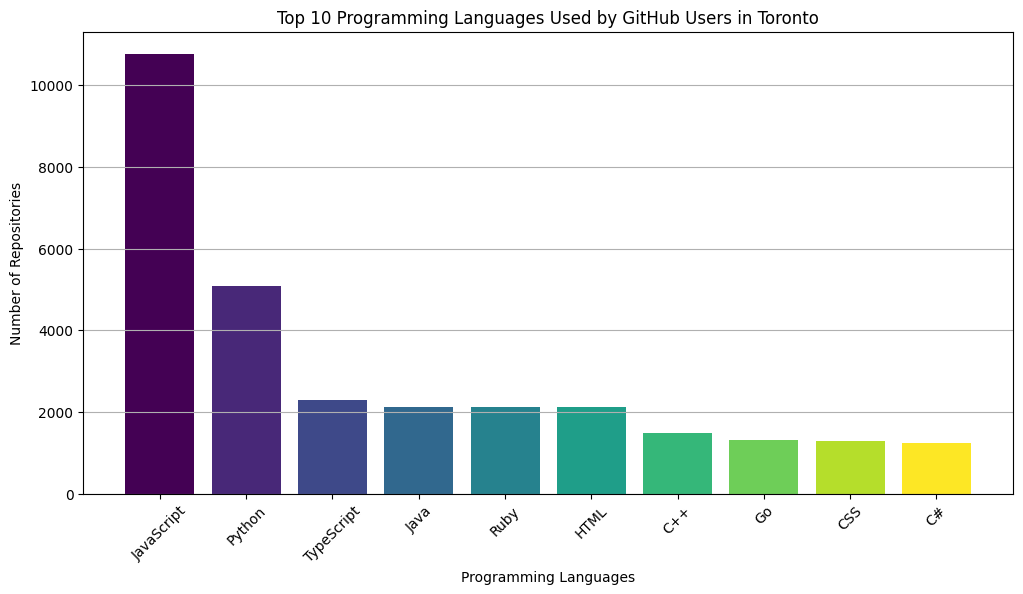

                     Language  Count
0                  JavaScript  10772
1                      Python   5077
2                  TypeScript   2287
3                        Java   2125
4                        Ruby   2123
..                        ...    ...
208               Vim Snippet      1
209                  VBScript      1
210  Common Workflow Language      1
211                     Dylan      1
212                    Stylus      1

[213 rows x 2 columns]


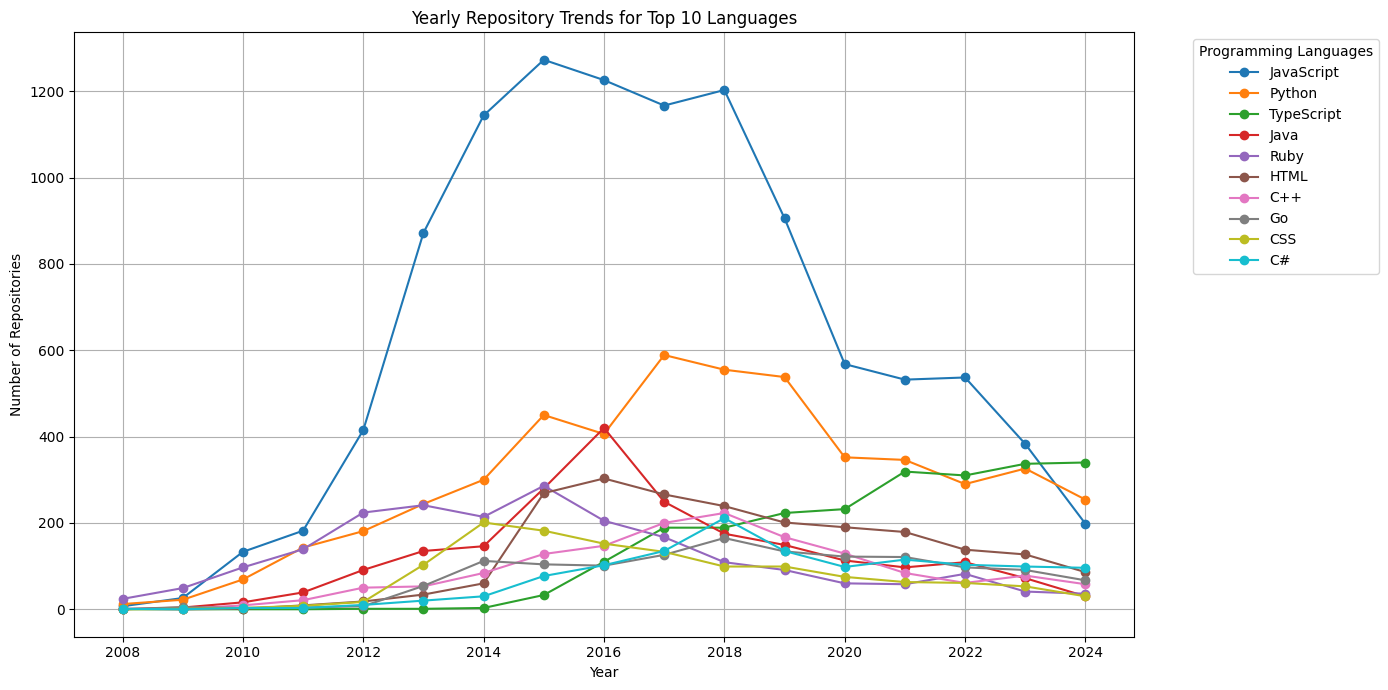

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
language_counts = repo_data['language'].value_counts().reset_index()
language_counts.columns = ['Language', 'Count']
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(language_counts['Language'][:10])))

plt.bar(language_counts['Language'][:10], language_counts['Count'][:10], color=colors)
plt.title('Top 10 Programming Languages Used by GitHub Users in Toronto')
plt.xlabel('Programming Languages')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('top_languages.png')
plt.show()
print(language_counts)
repo_data['created_at'] = pd.to_datetime(repo_data['created_at'])
repo_data['year'] = repo_data['created_at'].dt.year
trends = repo_data.groupby(['year', 'language']).size().unstack(fill_value=0)
top_languages = language_counts['Language'][:10]
top_trends = trends[top_languages]
plt.figure(figsize=(14, 7))
for language in top_languages:
    plt.plot(top_trends.index, top_trends[language], marker='o', label=language)

plt.title('Yearly Repository Trends for Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.legend(title='Programming Languages', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('top_10_language_yearly_trends.png')
plt.show()


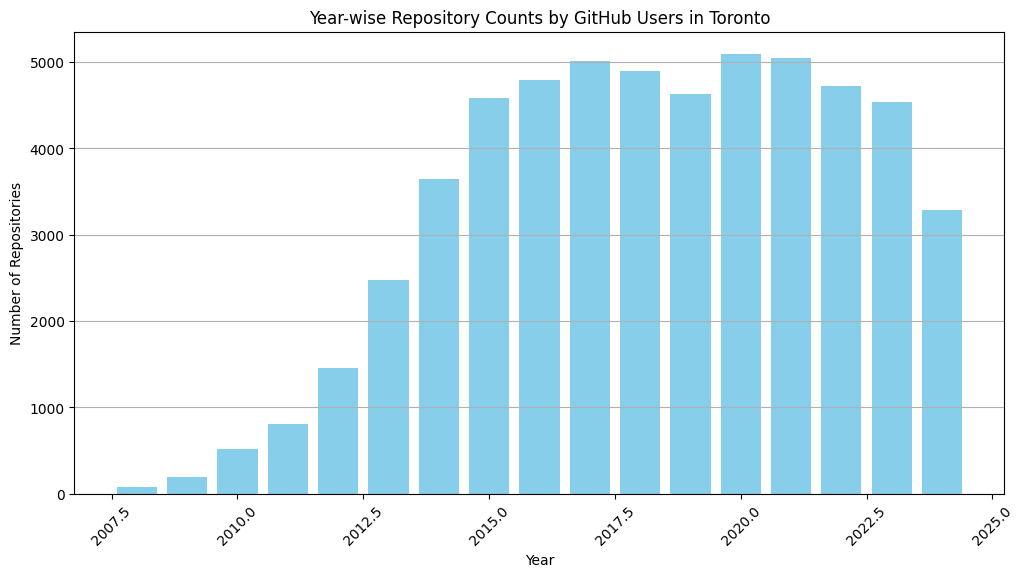

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
repo_data['created_at'] = pd.to_datetime(repo_data['created_at'])
repo_data['year'] = repo_data['created_at'].dt.year
yearly_counts = repo_data['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue')
plt.title('Year-wise Repository Counts by GitHub Users in Toronto')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('yearly_repository_counts.png')
plt.show()


--> The most interesting and surprising fact I found after analyzing the the data is JavaScript which is used in more than 10000 repos (from 1200 repos in 2018 to just 200 repos in 2024), JavaScript is not preferred by many developers these days. On top of that TypeScript is becoming popular along with python.



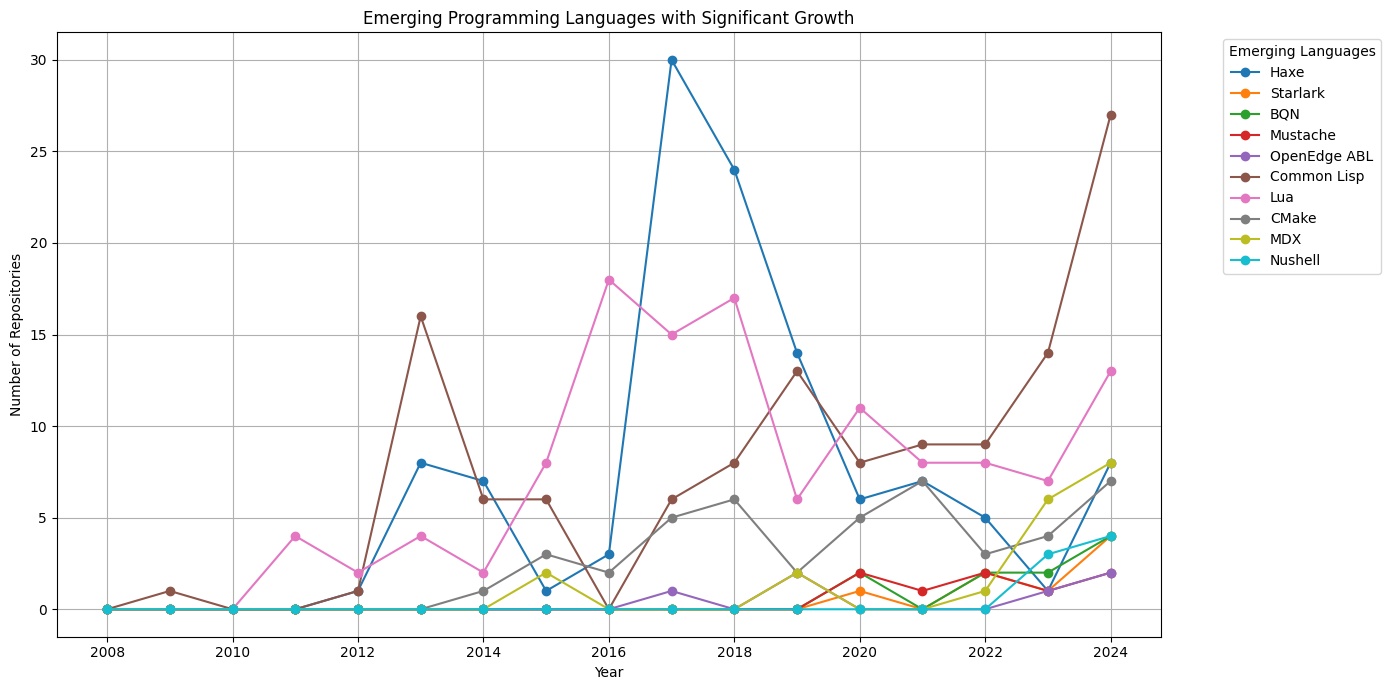

Emerging Languages with Significant Growth (Descending Order):
Haxe: Growth Rate: 700.00%
Starlark: Growth Rate: 300.00%
BQN: Growth Rate: 100.00%
Mustache: Growth Rate: 100.00%
OpenEdge ABL: Growth Rate: 100.00%
Common Lisp: Growth Rate: 92.86%
Lua: Growth Rate: 85.71%
CMake: Growth Rate: 75.00%
MDX: Growth Rate: 33.33%
Nushell: Growth Rate: 33.33%


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
repo_data['created_at'] = pd.to_datetime(repo_data['created_at'])
repo_data['year'] = repo_data['created_at'].dt.year

trends = repo_data.groupby(['year', 'language']).size().unstack(fill_value=0)
growth_rates = trends.pct_change().fillna(0)
latest_year = trends.index[-1]
recent_growth = growth_rates.loc[latest_year]
threshold = 0.2
emerging_languages = recent_growth[recent_growth > threshold]
emerging_languages = emerging_languages[~emerging_languages.isin([float('inf'), -float('inf')])]
sorted_emerging_languages = emerging_languages.sort_values(ascending=False)
plt.figure(figsize=(14, 7))

for language in sorted_emerging_languages.index:
    plt.plot(trends.index, trends[language], marker='o', label=language)

plt.title('Emerging Programming Languages with Significant Growth')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.legend(title='Emerging Languages', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('emerging_languages_trends.png')
plt.show()
print("Emerging Languages with Significant Growth (Descending Order):")
for lang, growth in sorted_emerging_languages.items():
    print(f"{lang}: Growth Rate: {growth:.2%}")


--> A Signinficant growth in emerging languages like Haxe,Starlark,BQN,Mustache,OpenEdge ABL has been observed. Hence developers in Toronto are recommended to upskill themselves in these languages.  



---

: